In [285]:
from FFNN import NeuralNetwork, train_network, train_network_momentum, train_network_stocastic_momentum, train_network_SRMSprop, train_network_stocastic_ADAM
import copy
import activation_functions as af
import cost_functions as cf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### Generate data
Using the same function and seed for generating data as in project 1.

In [286]:
def generate_data(n, noise = True):
    # Fixed seed value to ensure consisten results across runs
    seed = 42
    np.random.seed(seed)
    # Creating an array with equally spaced data
    x = np.linspace(-1, 1, n)
    # Runges equation with noise
    if noise:
        y = 1 / (1 + 25*x**2) +  np.random.normal(0, 0.1, size=n)
    else:
        y = 1 / (1 + 25*x**2)
    return x, y

In [287]:
n = 50
x, y = generate_data(n)
x = x.reshape(-1,1)
y = y.reshape(-1,1)

### Visualizing the data we are working with

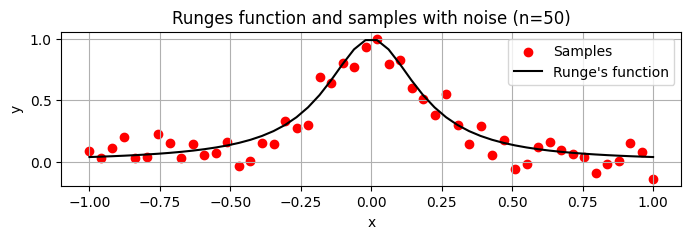

In [288]:
plt.figure(figsize=(8, 2))
plt.scatter(x, y, color='red', linewidth=1, label='Samples')
plt.plot(x, 1/(1+25*x**2), color = 'k', label = "Runge's function")
plt.title("Runges function and samples with noise (n=50)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

### Train, test split with validation sat

In [289]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Scaling inputs

In [290]:
# Scale inputs
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test  = scaler.transform(X_test)

### Training two neural networks
1. One that has 1 hidden layer with 50 nodes.
2. One that has 2 hidden layers with 50 and 100 nodes respectively.

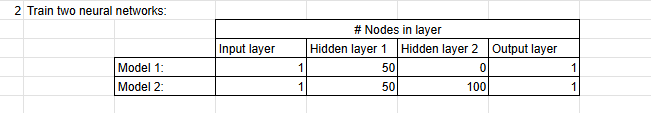

1 Hidden layer with 50 nodes:
MSE: 0.06131

2 Hidden layers with 50 and 100 nodes:
MSE : 0.01461


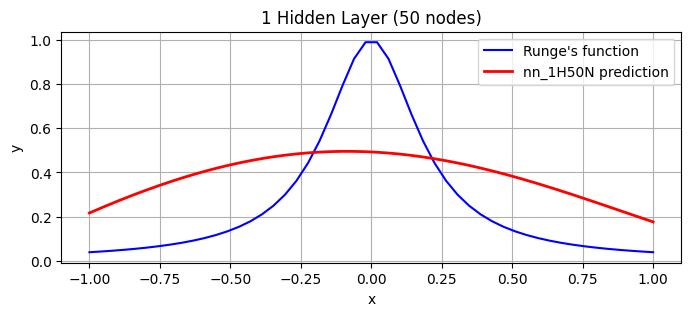

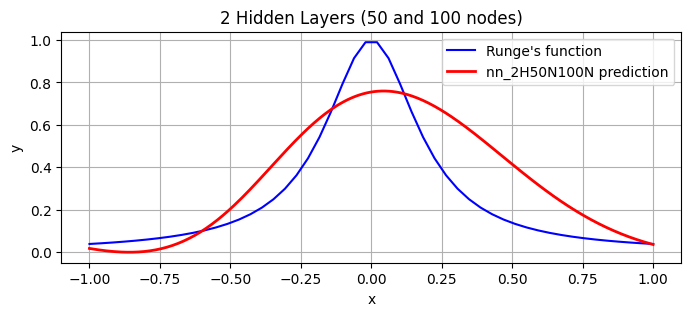

In [291]:
# Creating the neural networks
nn_1H50N = NeuralNetwork(
    network_input_size=x_train.shape[1],
    layer_output_sizes=[50, 1],
    activation_funcs=[af.sigmoid, af.identity],
    cost_func=cf.mse)

nn_2H50N100N = NeuralNetwork(
    network_input_size=x_train.shape[1],
    layer_output_sizes=[50, 100, 1],
    activation_funcs=[af.sigmoid, af.sigmoid, af.identity],
    cost_func=cf.mse)

# Training the neural network
train_network_stocastic_momentum(nn_1H50N, x_train, y_train, eta=0.01, epochs=100)
train_network_stocastic_momentum(nn_2H50N100N, x_train, y_train, eta=0.01, epochs=100)

# Predicting outputs
prediction_1 = nn_1H50N.predict(x_test)
prediction_2 = nn_2H50N100N.predict(x_test)

# Computing the MSE on unscaled data
mse_1layer = cf.mse(y_test, prediction_1)
mse_2layers = cf.mse(y_test, prediction_2)


print("1 Hidden layer with 50 nodes:\n=========================")
print(f"MSE: {mse_1layer:.5f}\n")

print("2 Hidden layers with 50 and 100 nodes:\n=========================")
print(f"MSE : {mse_2layers:.5f}")

# Prediction plot
x_plot = np.linspace(-1, 1, 300).reshape(-1, 1)

plt.figure(figsize=(8, 3))
plt.plot(x, 1 / (1 + 25 * x**2), label="Runge's function", color="blue")
plt.plot(x_plot, nn_1H50N.predict(x_plot), color="red", linewidth=2, label="nn_1H50N prediction")
plt.title("1 Hidden Layer (50 nodes)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(x, 1 / (1 + 25 * x**2), label="Runge's function", color="blue")
plt.plot(x_plot, nn_2H50N100N.predict(x_plot),color="red", linewidth=2, label="nn_2H50N100N prediction")
plt.title("2 Hidden Layers (50 and 100 nodes)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


### Hyperparameter tuning optimizer and learning rate

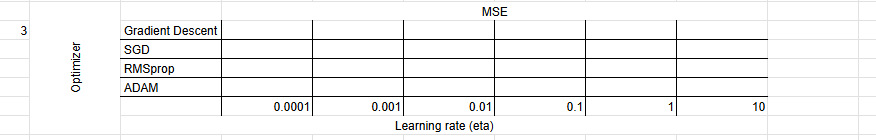

In [292]:
# When hyperparameterizing we want to find the parameters that perform best over a given amount of runs, since stochastic gradient descent methods are volatile in nature.
def update_counter(counter, matrix, labels_y, labels_x):
    # Tracks the combination with the lowest MSE for each run and accumulates it.
    min_idx = np.unravel_index(np.nanargmin(matrix), matrix.shape)
    label_y = labels_y[min_idx[0]]
    label_x = labels_x[min_idx[1]]
    counter[(label_y, label_x)] += 1

c:\Skole\Anvendt dataanalyse og Maskinlæring\FYS-STK3155\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
c:\Skole\Anvendt dataanalyse og Maskinlæring\FYS-STK3155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:125: RuntimeWarning: overflow encountered in square
  lambda ans, x, y: unbroadcast_f(y, lambda g: -g * x / y**2),
c:\Skole\Anvendt dataanalyse og Maskinlæring\FYS-STK3155\.venv\Lib\site-packages\autograd\numpy\numpy_vjps.py:160: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp, lambda ans, x: lambda g: ans * g)


Run 20/100
Run 40/100
Run 60/100
Run 80/100
Run 100/100

How often each combination achieved the lowest MSE:
('ADAM', '1.0000e-01'): 77 times
('ADAM', '1.0000e-02'): 17 times
('SGD', '1.0000e-02'): 6 times


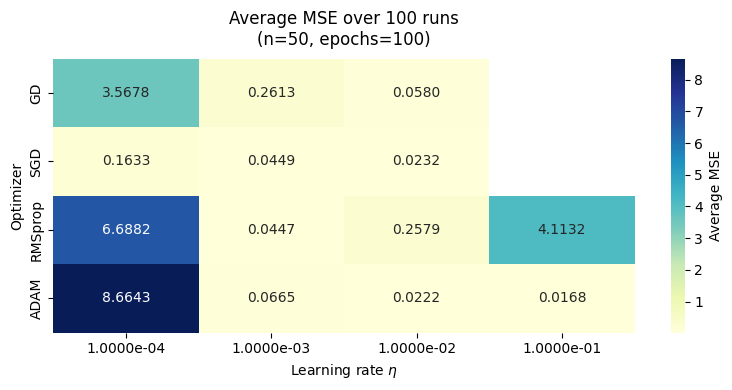

In [293]:
# Parameters we are tuning 
optimizers = [train_network,                    # Gradient descent
              train_network_stocastic_momentum, # Stochastic gradient descent with momentum
              train_network_SRMSprop,           # RMSProp
              train_network_stocastic_ADAM]     # ADAM

optimizer_labels = ["GD", "SGD", "RMSprop", "ADAM"]
learning_rates = np.logspace(-4, -1, num=4)
epochs = 100
runs = 100  # number of experiments

# Tracking
combination_counter = Counter()
avg_mse_matrix = np.zeros((len(optimizers), len(learning_rates)))

for run in range(runs):
    # Printing progress
    if (run + 1) % 20 == 0 or (run + 1) == runs:
        print(f"Run {run + 1}/{runs}")

    # Initialize a base network for this run
    base_nn = NeuralNetwork(
        x.shape[1],
        [50, 100, 1],
        [af.sigmoid, af.sigmoid, af.identity],
        cf.mse
    )
    layers_init = copy.deepcopy(base_nn.layers)

    mse_matrix = []

    # Iterating through all combinations of optimizers and learning rates, and calculate the corresponding MSE.
    for optimizer in optimizers:
        mse_row = []
        for eta in learning_rates:
            nn = NeuralNetwork(
                x.shape[1],
                [50, 100, 1],
                [af.sigmoid, af.sigmoid, af.identity],
                cf.mse)

            # Using the same weights and biases across all models
            nn.layers = copy.deepcopy(layers_init)

            optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
            predictions = nn.predict(x_test)
            mse = cf.mse(y_test, predictions)
            mse_row.append(mse)

        mse_matrix.append(mse_row)

    mse_matrix = np.array(mse_matrix)

    # Accumulate MSEs across all runs
    avg_mse_matrix += mse_matrix

    # Find the combination with the lowest MSE for this run
    update_counter(combination_counter, mse_matrix, optimizer_labels, [f"{lr:.4e}" for lr in learning_rates])

# Average MSE across all runs
avg_mse_matrix /= runs

print("\nHow often each combination achieved the lowest MSE:")
for combo, count in combination_counter.most_common():
    print(f"{combo}: {count} times")


# Heatmap of the average MSE
plt.figure(figsize=(8, 4))
sns.heatmap(avg_mse_matrix, annot=True, fmt=".4f", cmap="YlGnBu", xticklabels=[f"{lr:.4e}" for lr in learning_rates], yticklabels=optimizer_labels, cbar_kws={"label": "Average MSE"})

plt.title(f"Average MSE over {runs} runs\n(n={50}, epochs={epochs})", fontsize=12, pad=10)
plt.xlabel(r"Learning rate $\eta$")
plt.ylabel("Optimizer")
plt.tight_layout()
plt.show()


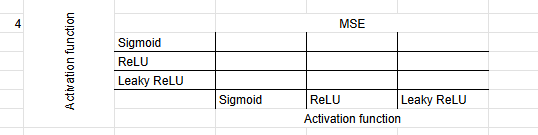

Run 20/100
Run 40/100
Run 60/100
Run 80/100
Run 100/100

How often each combination achieved the lowest MSE:
('Sigmoid', 'Sigmoid'): 70 times
('ReLU', 'Sigmoid'): 12 times
('Leaky ReLU', 'Sigmoid'): 11 times
('Leaky ReLU', 'Leaky ReLU'): 3 times
('Leaky ReLU', 'ReLU'): 1 times
('ReLU', 'ReLU'): 1 times
('Sigmoid', 'ReLU'): 1 times
('ReLU', 'Leaky ReLU'): 1 times


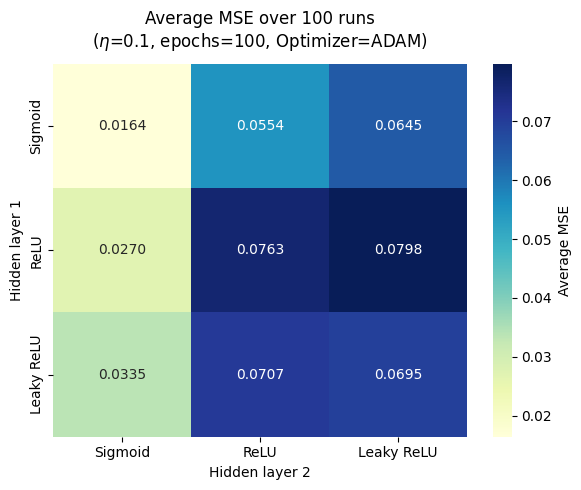

In [294]:
optimizer = train_network_stocastic_ADAM
eta = 1e-1
epochs = 100
runs = 100  # number of experiments

# Activation functions we are iterating over
activation_functions = [af.sigmoid, af.ReLU, af.leaky_ReLU]
activation_labels = ["Sigmoid", "ReLU", "Leaky ReLU"]

# Tracking
combination_counter = Counter()
avg_mse_matrix = np.zeros((len(activation_functions), len(activation_functions)))

for run in range(runs):
    # Printing progress
    if (run + 1) % 20 == 0:
        print(f"Run {run + 1}/{runs}")

    # Initialize a new base for this run
    base_nn = NeuralNetwork(
        x.shape[1],
        [50, 100, 1],
        [af.sigmoid, af.sigmoid, af.identity],
        cf.mse)
    
    # Using the same weights and biases across all models
    layers_init = copy.deepcopy(base_nn.layers)

    mse_matrix = []

    # Iterating through all the different combinations of activations functions for two hidden layers, and calculate the corresponding MSE.
    for hidden1 in activation_functions:
        mse_row = []
        for hidden2 in activation_functions:
            nn = NeuralNetwork(
                x.shape[1],
                [50, 100, 1],
                [hidden1, hidden2, af.identity],
                cf.mse)
            # Using the same weights and biases across all models
            nn.layers = copy.deepcopy(layers_init)

            optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
            predictions = nn.predict(x_test)
            mse = cf.mse(y_test, predictions)
            mse_row.append(mse)
        mse_matrix.append(mse_row)

    mse_matrix = np.array(mse_matrix)
    
    # Accumulate MSEs across all runs
    avg_mse_matrix += mse_matrix  

    # Find the combination with the lowest MSE this run
    update_counter(combination_counter, mse_matrix, activation_labels, activation_labels)

# Average MSE across all runs
avg_mse_matrix /= runs

print("\nHow often each combination achieved the lowest MSE:")
for combo, count in combination_counter.most_common():
    print(f"{combo}: {count} times")


# Heatmap of the average MSE
plt.figure(figsize=(6, 5))
sns.heatmap(avg_mse_matrix, annot=True, fmt=".4f", cmap="YlGnBu", xticklabels=activation_labels, yticklabels=activation_labels, cbar_kws={"label": "Average MSE"})

plt.title(f"Average MSE over {runs} runs\n($\\eta$={eta}, epochs={epochs}, Optimizer=ADAM)", fontsize=12, pad=12)
plt.xlabel("Hidden layer 2")
plt.ylabel("Hidden layer 1")
plt.tight_layout()
plt.show()


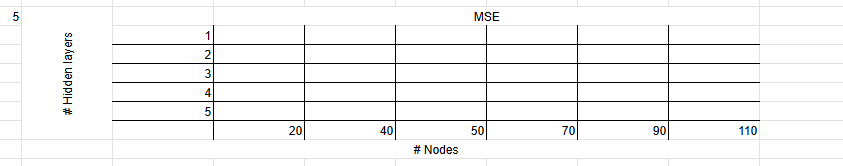

Run 20/100
Run 40/100
Run 60/100
Run 80/100
Run 100/100

How often each combination achieved the lowest MSE:
('40', '100'): 18 times
('40', '80'): 15 times
('40', '60'): 14 times
('40', '40'): 13 times
('60', '100'): 8 times
('60', '60'): 7 times
('60', '80'): 6 times
('60', '20'): 3 times
('60', '40'): 3 times
('80', '80'): 3 times
('20', '20'): 2 times
('80', '100'): 2 times
('80', '60'): 1 times
('20', '100'): 1 times
('20', '60'): 1 times
('20', '40'): 1 times
('40', '20'): 1 times
('100', '100'): 1 times


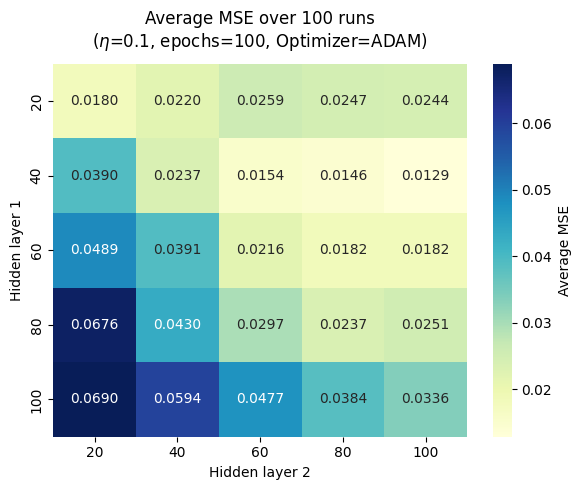

In [295]:
optimizer = train_network_stocastic_ADAM
activation_functions = [af.sigmoid, af.sigmoid, af.identity]
eta = 1e-1
epochs = 100
runs = 100  # number of experiments

# Number of nodes we are iterating over
num_nodes = [20, 40, 60, 80, 100]
labels =  ["20", "40", "60", "80", "100"]

# Tracking
combination_counter = Counter()
avg_mse_matrix = np.zeros((len(num_nodes), len(num_nodes)))

for run in range(runs):
    # Printing progress
    if (run + 1) % 20 == 0:
        print(f"Run {run + 1}/{runs}")

    mse_matrix = []

    # Iterating through different amount of nodes in the two hidden layers, and calculate the corresponding MSE
    for hidden1 in num_nodes:
        mse_row = []
        for hidden2 in num_nodes:
            nn = NeuralNetwork(
                x.shape[1],
                [hidden1, hidden2, 1],
                activation_functions,
                cf.mse)

            optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
            predictions = nn.predict(x_test)
            mse = cf.mse(y_test, predictions)
            mse_row.append(mse)
        mse_matrix.append(mse_row)

    mse_matrix = np.array(mse_matrix)
    
    # Accumulate MSEs across all runs
    avg_mse_matrix += mse_matrix  

    # Find the combination with the lowest MSE this run
    update_counter(combination_counter, mse_matrix, labels, labels)


# Average MSE across all runs
avg_mse_matrix /= runs

print("\nHow often each combination achieved the lowest MSE:")
for combo, count in combination_counter.most_common():
    print(f"{combo}: {count} times")


# Heatmap of the average MSE
plt.figure(figsize=(6, 5))
sns.heatmap(avg_mse_matrix, annot=True, fmt=".4f", cmap="YlGnBu", xticklabels=labels, yticklabels=labels, cbar_kws={"label": "Average MSE"})

plt.title(f"Average MSE over {runs} runs\n($\\eta$={eta}, epochs={epochs}, Optimizer=ADAM)", fontsize=12, pad=12)
plt.xlabel("Hidden layer 2")
plt.ylabel("Hidden layer 1")
plt.tight_layout()
plt.show()



Run 20/100
Run 40/100
Run 60/100
Run 80/100
Run 100/100


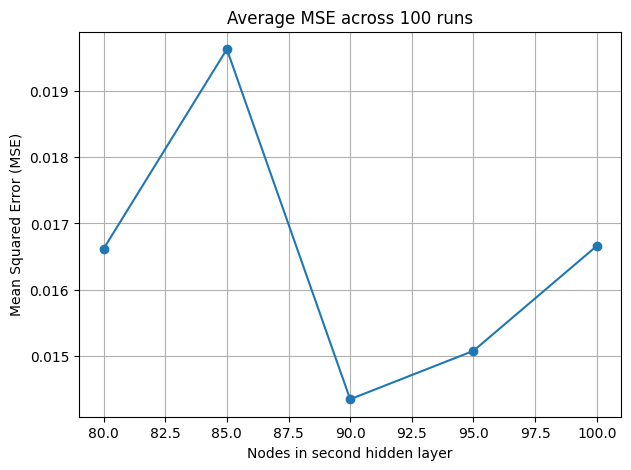

In [296]:
optimizer = train_network_stocastic_ADAM
activation_functions = [af.sigmoid, af.sigmoid, af.identity]
eta = 1e-1
epochs = 100
runs = 100  # number of experiments
hidden1 = 40

num_nodes = [80, 85, 90, 95, 100]
labels = ["80", "85", "90", "95", "100"]

# Store MSE results for all runs
mse_all_runs = np.zeros((runs, len(num_nodes)))

for run in range(runs):
    if (run + 1) % 20 == 0:
        print(f"Run {run + 1}/{runs}")

    # For each number of nodes in the 2nd hidden layer
    for i, hidden2 in enumerate(num_nodes):
        nn = NeuralNetwork(
            x.shape[1],
            [hidden1, hidden2, 1],
            activation_functions,
            cf.mse)

        optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)
        predictions = nn.predict(x_test)
        mse = cf.mse(y_test, predictions)
        mse_all_runs[run, i] = mse

# Compute average MSE across runs
avg_mse = np.mean(mse_all_runs, axis=0)

# Plot of the average MSE 
plt.figure(figsize=(7, 5))
plt.errorbar(num_nodes, avg_mse, fmt='o-', capsize=4)
plt.title("Average MSE across 100 runs")
plt.xlabel("Nodes in second hidden layer")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.show()


In [308]:
optimizer = train_network_stocastic_ADAM
activation_functions = [af.sigmoid, af.sigmoid, af.identity]
eta = 1e-1
epochs = 100
hidden1 =40
hidden2= 100

nn = NeuralNetwork(
            x.shape[1],
            [hidden1, hidden2, 1],
            activation_functions,
            cf.mse)

optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)

# Compute MSE on the final model
predictions_test = nn.predict(x_test)
mse = cf.mse(y_test, predictions_test)
print(f"MSE after tuning hyperparameters: {mse}")

MSE after tuning hyperparameters: 0.010648239353247385


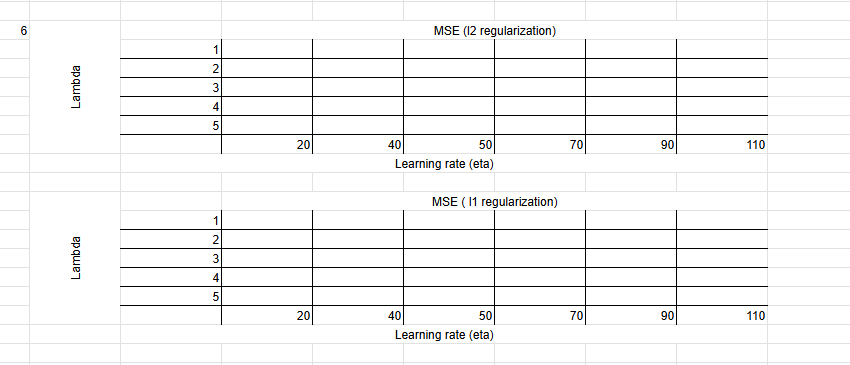

### Regularization
#### L2 Regularization

MSE after tuning hyperparameters: 0.059982972559774264


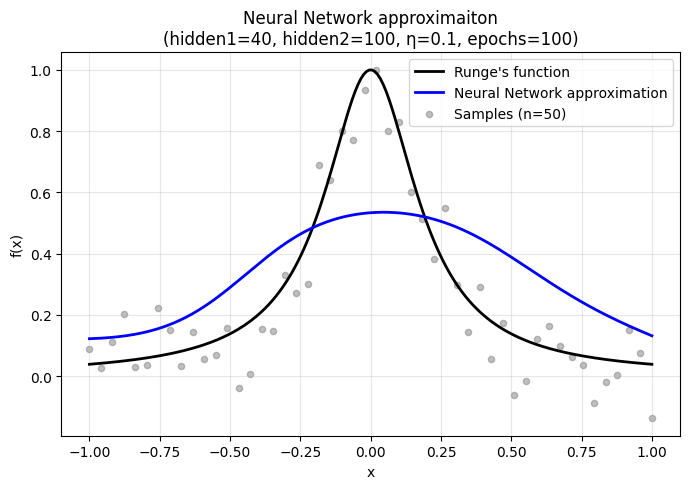

In [ ]:
optimizer = train_network_stocastic_ADAM
activation_functions = [af.sigmoid, af.sigmoid, af.identity]
eta = 1e-1
epochs = 100
hidden1 = 40
hidden2= 100

nn = NeuralNetwork(
            x.shape[1],
            [hidden1, hidden2, 1],
            activation_functions,
            cf.mse)

optimizer(nn, x_train, y_train, eta=eta, epochs=epochs)

# Compute MSE on the final model
predictions_test = nn.predict(X_test)
mse = cf.mse(y_test, predictions_test)
print(f"MSE after tuning hyperparameters: {mse}")
# Generate smooth x values for plotting
x_plot = np.linspace(-1, 1, 200).reshape(-1, 1)

# NN predictions for plotting
y_pred = nn.predict(x_plot)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(x_plot, 1/(1+25*x_plot**2), label="Runge's function", color="black", linewidth=2)
plt.plot(x_plot, y_pred, label="Neural Network approximation", color="blue", linestyle="-", linewidth=2)

# Scatter your training data (optional)
plt.scatter(x, y, color="gray", alpha=0.5, label=f"Samples (n={n})", s=20)

plt.xlabel("x")
plt.ylabel("f(x)")
plt.title(f"Neural Network approximaiton\n(hidden1={hidden1}, hidden2={hidden2}, η={eta}, epochs={epochs})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




#### L1 Regularization